In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.utils.class_weight import compute_class_weight
RANDOM_STATE = 420
TARGET_COLUMN = 'Wildfire_bin'
YEAR_COLUMN = 'year'

In [2]:
train_val_data_path = "./Data/dataset_with_terrain_new_train_2014_2021.csv"
train_val_data = pd.read_csv(train_val_data_path)
test_data_path = "./Data/dataset_with_terrain_new_test_2022_2025.csv"
test_data = pd.read_csv(test_data_path)

In [3]:
train_val_data.columns

Index(['latitude', 'longitude', 'datetime', 'loc_id', 'runtime',
       'frame75_loc_id', 'elevation_m', 'slope_deg', 'since_prev_pr', 'pr_sum',
       'pr_max', 'Wildfire_bin', 'pr_mean_rt_50_59', 'rmax_mean_rt_50_59',
       'rmin_mean_rt_50_59', 'sph_mean_rt_50_59', 'srad_mean_rt_50_59',
       'tmmn_mean_rt_50_59', 'tmmx_mean_rt_50_59', 'vs_mean_rt_50_59',
       'bi_mean_rt_50_59', 'fm100_mean_rt_50_59', 'fm1000_mean_rt_50_59',
       'erc_mean_rt_50_59', 'etr_mean_rt_50_59', 'pet_mean_rt_50_59',
       'vpd_mean_rt_50_59', 'doy', 'doy_sin', 'doy_cos', 'weekday_weekend',
       'month', 'season', 'weekday_sin', 'weekday_cos', 'nlcd_fuel_continuity',
       'nlcd_canopy_height_class', 'nlcd_flammability', 'nlcd_human_presence',
       'nlcd_fuel_regime_class', 'nlcd_water_ice_barren', 'nlcd_wetland',
       'nlcd_forest', 'nlcd_shrub', 'nlcd_grass_pasture', 'nlcd_crops',
       'nlcd_developed', 'hdw_score', 't_range_mean_rt_50_59',
       'nlcd_wui_intensity', 'dryness_score', 'dr

In [4]:
# 20% of the original training data will be used for validation
VAL_SIZE = 0.2  # adjust if needed
train_data, val_data = train_test_split(
    train_val_data,
    test_size=VAL_SIZE,
    stratify=train_val_data[TARGET_COLUMN],  # preserves class balance
    random_state=RANDOM_STATE,
)

In [5]:
y_train = train_data['Wildfire_bin']
y_val = val_data['Wildfire_bin']
y_test = test_data['Wildfire_bin']
year_test = test_data[YEAR_COLUMN] # Store years separately for year-wise analysis

In [6]:
train_data.columns

Index(['latitude', 'longitude', 'datetime', 'loc_id', 'runtime',
       'frame75_loc_id', 'elevation_m', 'slope_deg', 'since_prev_pr', 'pr_sum',
       'pr_max', 'Wildfire_bin', 'pr_mean_rt_50_59', 'rmax_mean_rt_50_59',
       'rmin_mean_rt_50_59', 'sph_mean_rt_50_59', 'srad_mean_rt_50_59',
       'tmmn_mean_rt_50_59', 'tmmx_mean_rt_50_59', 'vs_mean_rt_50_59',
       'bi_mean_rt_50_59', 'fm100_mean_rt_50_59', 'fm1000_mean_rt_50_59',
       'erc_mean_rt_50_59', 'etr_mean_rt_50_59', 'pet_mean_rt_50_59',
       'vpd_mean_rt_50_59', 'doy', 'doy_sin', 'doy_cos', 'weekday_weekend',
       'month', 'season', 'weekday_sin', 'weekday_cos', 'nlcd_fuel_continuity',
       'nlcd_canopy_height_class', 'nlcd_flammability', 'nlcd_human_presence',
       'nlcd_fuel_regime_class', 'nlcd_water_ice_barren', 'nlcd_wetland',
       'nlcd_forest', 'nlcd_shrub', 'nlcd_grass_pasture', 'nlcd_crops',
       'nlcd_developed', 'hdw_score', 't_range_mean_rt_50_59',
       'nlcd_wui_intensity', 'dryness_score', 'dr

In [7]:
#Removing the features which are technical identifiers, highly correlated, the target variable or the ones which are already implicitly encoded in other features
train_data = train_data.drop(columns=['runtime', 'frame75_loc_id', 'loc_id', 'datetime', 'doy', 'year', 'month', 'season', 'weekday_sin', 'weekday_cos', 'hdw_score', 'weekday_weekend', 'vpd_times_wind', 'dry_on_slope', 'wnd_slope', 'nlcd_wui_intensity', 'dryness_score', 'fm100_mean_rt_50_59', 't_range_mean_rt_50_59', 'pr_mean_rt_50_59', 'pet_mean_rt_50_59', 'Wildfire_bin'])
val_data = val_data.drop(columns=['runtime', 'frame75_loc_id', 'loc_id', 'datetime', 'doy', 'year', 'month', 'season', 'weekday_sin', 'weekday_cos', 'hdw_score', 'weekday_weekend', 'vpd_times_wind', 'dry_on_slope', 'wnd_slope', 'nlcd_wui_intensity', 'dryness_score', 'fm100_mean_rt_50_59', 't_range_mean_rt_50_59', 'pr_mean_rt_50_59', 'pet_mean_rt_50_59', 'Wildfire_bin'])
test_data = test_data.drop(columns=['runtime', 'frame75_loc_id', 'loc_id', 'datetime', 'doy', 'year', 'month', 'season', 'weekday_sin', 'weekday_cos', 'hdw_score', 'weekday_weekend', 'vpd_times_wind', 'dry_on_slope', 'wnd_slope', 'nlcd_wui_intensity', 'dryness_score', 'fm100_mean_rt_50_59', 't_range_mean_rt_50_59', 'pr_mean_rt_50_59', 'pet_mean_rt_50_59', 'Wildfire_bin'])

In [8]:
X_train = train_data
X_val = val_data
X_test = test_data

In [9]:
#Just checking for any null values and categorical columns 
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85120 entries, 8894 to 57197
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitude                  85120 non-null  float64
 1   longitude                 85120 non-null  float64
 2   elevation_m               85120 non-null  float64
 3   slope_deg                 85120 non-null  float64
 4   since_prev_pr             85120 non-null  int64  
 5   pr_sum                    85120 non-null  float64
 6   pr_max                    85120 non-null  float64
 7   rmax_mean_rt_50_59        85120 non-null  float64
 8   rmin_mean_rt_50_59        85120 non-null  float64
 9   sph_mean_rt_50_59         85120 non-null  float64
 10  srad_mean_rt_50_59        85120 non-null  float64
 11  tmmn_mean_rt_50_59        85120 non-null  float64
 12  tmmx_mean_rt_50_59        85120 non-null  float64
 13  vs_mean_rt_50_59          85120 non-null  float64
 14  bi_mean_

In [10]:
#Analyze the class distribution for each unique value to check for imbalance
def analyze_class_distribution(y_data, dataset_name):
    class_counts = y_data.value_counts()
    class_ratios = y_data.value_counts(normalize=True)
    print(f"\n{dataset_name} Class Distribution:")
    for class_label, count in class_counts.items():
        print(f"  Class {class_label}: {count} samples ({class_ratios[class_label]:.2%})")
    imbalance_ratio = class_counts.max() / class_counts.min()
    print(f"  Imbalance Ratio: {imbalance_ratio:.2f}:1")
    return class_counts, imbalance_ratio

# Analyze all datasets
train_counts, train_ratio = analyze_class_distribution(y_train, "Training")
val_counts, val_ratio = analyze_class_distribution(y_val, "Validation")
test_counts, test_ratio = analyze_class_distribution(y_test, "Test")


Training Class Distribution:
  Class 0: 67875 samples (79.74%)
  Class 1: 17245 samples (20.26%)
  Imbalance Ratio: 3.94:1

Validation Class Distribution:
  Class 0: 16970 samples (79.74%)
  Class 1: 4311 samples (20.26%)
  Imbalance Ratio: 3.94:1

Test Class Distribution:
  Class 1: 11302 samples (58.10%)
  Class 0: 8152 samples (41.90%)
  Imbalance Ratio: 1.39:1


In [12]:
def evaluate_model(model, X_test, y_test, year_test, test_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    # Standard metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    # Imbalance-specific metrics
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    # ROC AUC score
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    
    print(f"\n{'-'*60}")
    print(f"RESULTS for {test_name}:")
    print(f"{'-'*60}")
    print(f"Accuracy:          {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    print(f"ROC AUC:           {roc_auc:.4f}")
    print(f"Precision:         {precision:.4f}")
    print(f"Recall:            {recall:.4f}")
    print(f"F1-Score:          {f1:.4f}")
    # Print class-wise performance
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y_test), 
                yticklabels=np.unique(y_test))
    plt.title(f'Confusion Matrix - {test_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Create results dataframe with years
    results_df = pd.DataFrame({
        'true': y_test,
        'pred': y_pred,
        'year': year_test
    })
    results_df = results_df.reset_index(drop=True)
    # Calculate metrics for each year
    metrics_by_year = []
    for year in sorted(results_df['year'].unique()):
        year_data = results_df[results_df['year'] == year]
        y_true_year = year_data['true']
        y_pred_year = year_data['pred']
        if len(y_true_year) > 0:
            # Calculate ROC AUC for each year
            year_probs = model.predict_proba(X_test[year_test == year])[:, 1]
            year_roc_auc = roc_auc_score(y_true_year, year_probs)
            
            metrics = {
                'year': year,
                'accuracy': accuracy_score(y_true_year, y_pred_year),
                'balanced_accuracy': balanced_accuracy_score(y_true_year, y_pred_year),
                'roc_auc': year_roc_auc,
                'f1_score': f1_score(y_true_year, y_pred_year, average='weighted'),
                'samples': len(y_true_year)
            }
            metrics_by_year.append(metrics)
    metrics_df = pd.DataFrame(metrics_by_year)
    # Create the line graph
    plt.figure(figsize=(12, 6))
    # Plot all metrics as lines
    plt.plot(metrics_df['year'], metrics_df['accuracy'], 
             marker='o', linewidth=2, markersize=8, label='Accuracy')
    plt.plot(metrics_df['year'], metrics_df['balanced_accuracy'], 
             marker='s', linewidth=2, markersize=8, label='Balanced Accuracy')
    plt.plot(metrics_df['year'], metrics_df['roc_auc'], 
             marker='D', linewidth=2, markersize=8, label='ROC AUC')
    plt.plot(metrics_df['year'], metrics_df['f1_score'], 
             marker='^', linewidth=2, markersize=8, label='F1-Score')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Year-wise Model Performance Metrics', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.05)
    # Add value annotations on points
    for _, row in metrics_df.iterrows():
        plt.annotate(f"{row['accuracy']:.3f}", 
                    (row['year'], row['accuracy']), 
                    textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)
        plt.annotate(f"{row['balanced_accuracy']:.3f}", 
                    (row['year'], row['balanced_accuracy']), 
                    textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)
        plt.annotate(f"{row['roc_auc']:.3f}", 
                    (row['year'], row['roc_auc']), 
                    textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)
        plt.annotate(f"{row['f1_score']:.3f}", 
                    (row['year'], row['f1_score']), 
                    textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)
    # Add sample sizes below x-axis
    for _, row in metrics_df.iterrows():
        plt.annotate(f"n={row['samples']}", 
                    (row['year'], -0.1), 
                    textcoords="offset points", 
                    xytext=(0,-15), ha='center', fontsize=9, 
                    color='gray', style='italic')
    
    plt.tight_layout()
    plt.show()
    # Print summary table
    print("\nYear-wise Performance Summary:")
    print("=" * 80)
    print(f"{'Year':>6} {'Samples':>8} {'Accuracy':>10} {'Balanced Acc':>12} {'ROC AUC':>10} {'F1-Score':>10}")
    print("-" * 80)
    for _, row in metrics_df.iterrows():
        print(f"{row['year']:>6} {row['samples']:>8} {row['accuracy']:>10.3f} "
              f"{row['balanced_accuracy']:>12.3f} {row['roc_auc']:>10.3f} {row['f1_score']:>10.3f}")
        
    return {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_accuracy,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'year_metrics': results_df,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

In [13]:
# Define parameter grid for hyperparamter optimization
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

print("Starting hyperparameter optimization using validation set...")

# Initialize base model with balanced class weight to handle class imbalance
base_rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
# Use GridSearchCV but with pre-defined validation set
grid_search = GridSearchCV(
    estimator=base_rf,
    param_grid=param_grid,
    cv=[(np.arange(len(X_train)), np.arange(len(X_train), len(X_train) + len(X_val)))],  # Use the predefined train/val split instead of cross validation
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
# Fit on combined train + val data
X_train_val_combined = pd.concat([X_train, X_val], axis=0)
y_train_val_combined = pd.concat([y_train, y_val], axis=0)
grid_search.fit(X_train_val_combined, y_train_val_combined)

print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best validation balanced accuracy: {grid_search.best_score_:.4f}")

Starting hyperparameter optimization using validation set...
Fitting 1 folds for each of 216 candidates, totalling 216 fits


/opt/conda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best parameters found:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best validation balanced accuracy: 0.7276


In [14]:
# Train final model with best parameters
final_model = RandomForestClassifier(
    **grid_search.best_params_,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
# Train on combined training + validation data
final_model.fit(X_train_val_combined, y_train_val_combined)

print("Final model trained on combined training + validation data.")
print(f"Model parameters: {final_model.get_params()}")

Final model trained on combined training + validation data.
Model parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 300, 'n_jobs': -1, 'oob_score': False, 'random_state': 420, 'verbose': 0, 'warm_start': False}



------------------------------------------------------------
RESULTS for Final Test Set:
------------------------------------------------------------
Accuracy:          0.4784
Balanced Accuracy: 0.5459
ROC AUC:           0.6556
Precision:         0.6677
Recall:            0.4784
F1-Score:          0.3839

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.96      0.61      8152
           1       0.83      0.13      0.22     11302

    accuracy                           0.48     19454
   macro avg       0.64      0.55      0.42     19454
weighted avg       0.67      0.48      0.38     19454



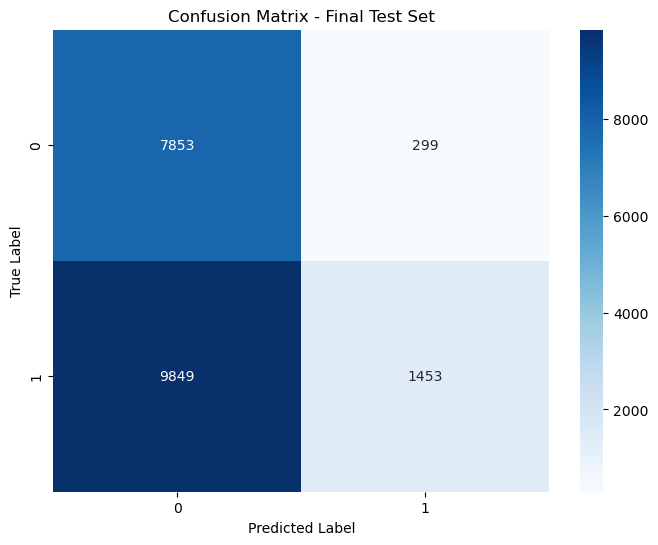

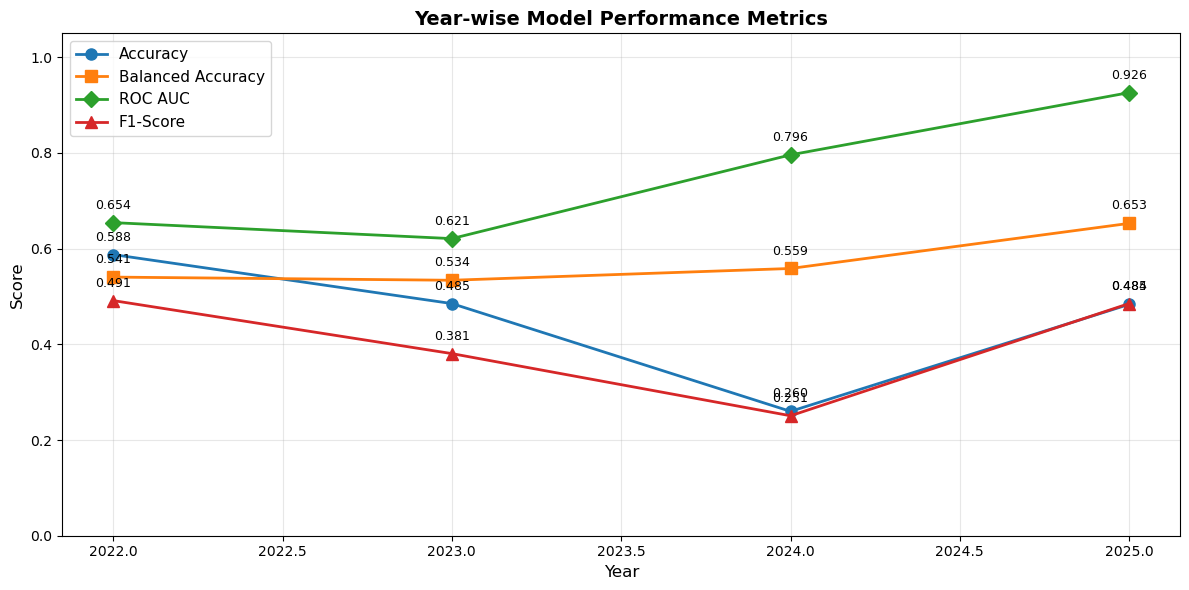


Year-wise Performance Summary:
  Year  Samples   Accuracy Balanced Acc    ROC AUC   F1-Score
--------------------------------------------------------------------------------
2022.0   8196.0      0.588        0.541      0.654      0.491
2023.0   6488.0      0.485        0.534      0.621      0.381
2024.0   4313.0      0.260        0.559      0.796      0.251
2025.0    457.0      0.484        0.653      0.926      0.485

FINAL MODEL PERFORMANCE SUMMARY
Balanced Accuracy on Test Set: 0.5459
F1-Score on Test Set: 0.3839


In [15]:
# Evaluate on test set
test_results = evaluate_model(final_model, X_test, y_test, year_test, "Final Test Set")

print("\n" + "="*70)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*70)
print(f"Balanced Accuracy on Test Set: {test_results['balanced_accuracy']:.4f}")
print(f"F1-Score on Test Set: {test_results['f1']:.4f}")


Top 10 Most Important Features:
                 feature  importance
1              longitude    0.061320
0               latitude    0.057748
14      bi_mean_rt_50_59    0.049470
2            elevation_m    0.047121
5                 pr_sum    0.046200
8     rmin_mean_rt_50_59    0.044208
33       erc_over_fm1000    0.042737
15  fm1000_mean_rt_50_59    0.042496
16     erc_mean_rt_50_59    0.042134
7     rmax_mean_rt_50_59    0.040705


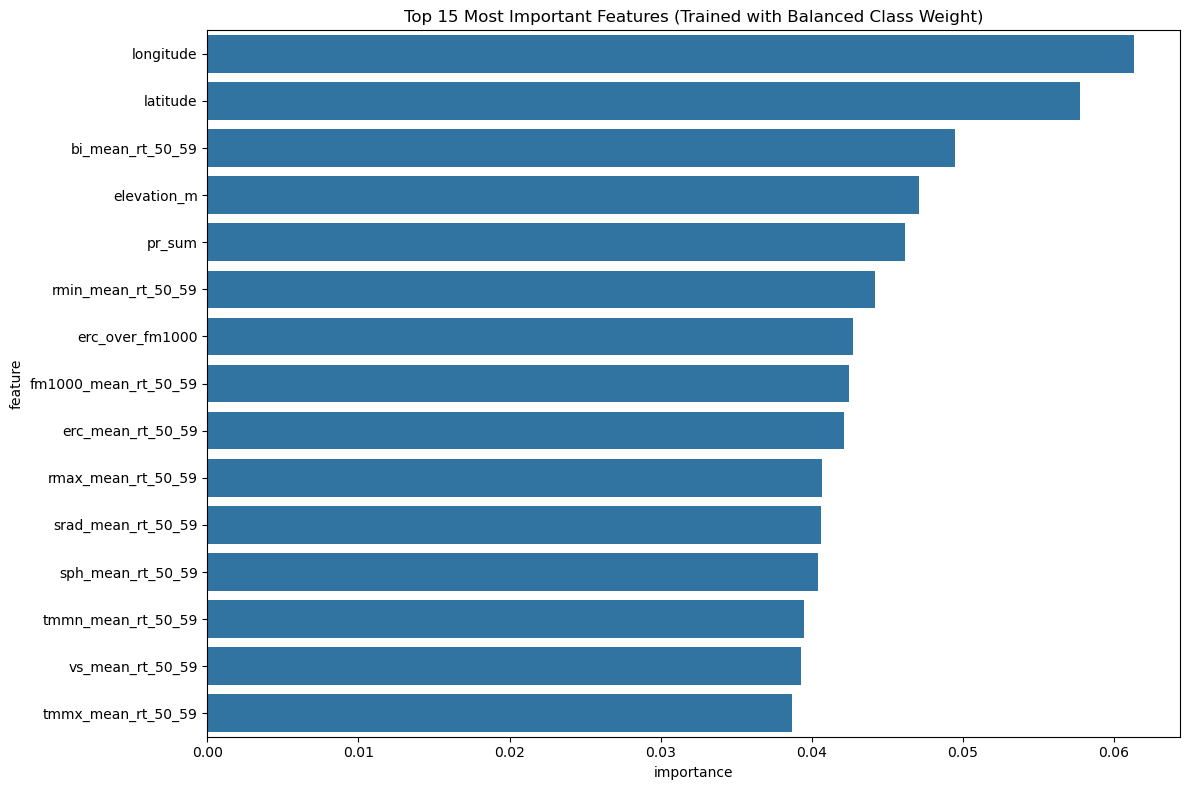

In [16]:
# Feature importance from the final model
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features (Trained with Balanced Class Weight)')
plt.tight_layout()
plt.show()

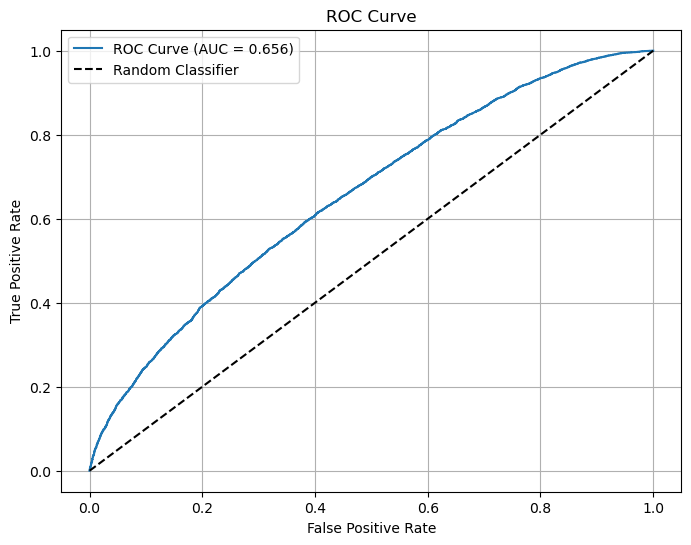

In [17]:
# ROC Curve and AUC
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_results['probabilities'][:,1])

# Compute AUC score
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

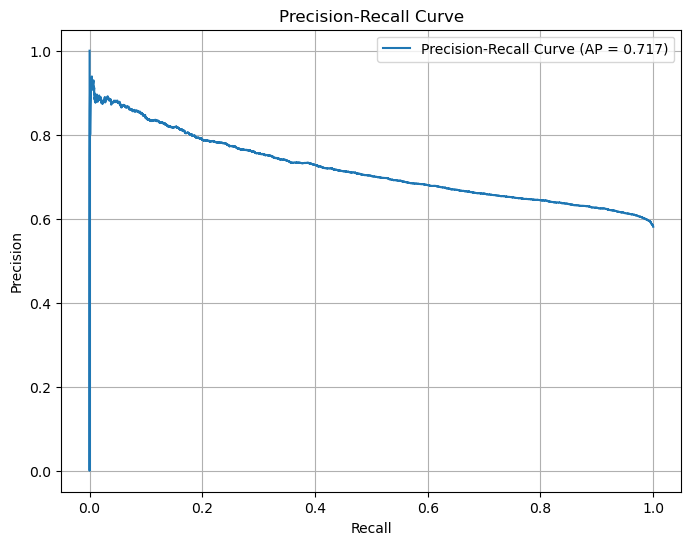

In [18]:
#Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, test_results['probabilities'][:, 1])
average_precision = average_precision_score(y_test, test_results['probabilities'][:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f'Precision-Recall Curve (AP = {average_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


Performance Comparison:
      Dataset   ROC_AUC  F1_Score
0  Validation  0.997924  0.990171
1        Test  0.655617  0.383891


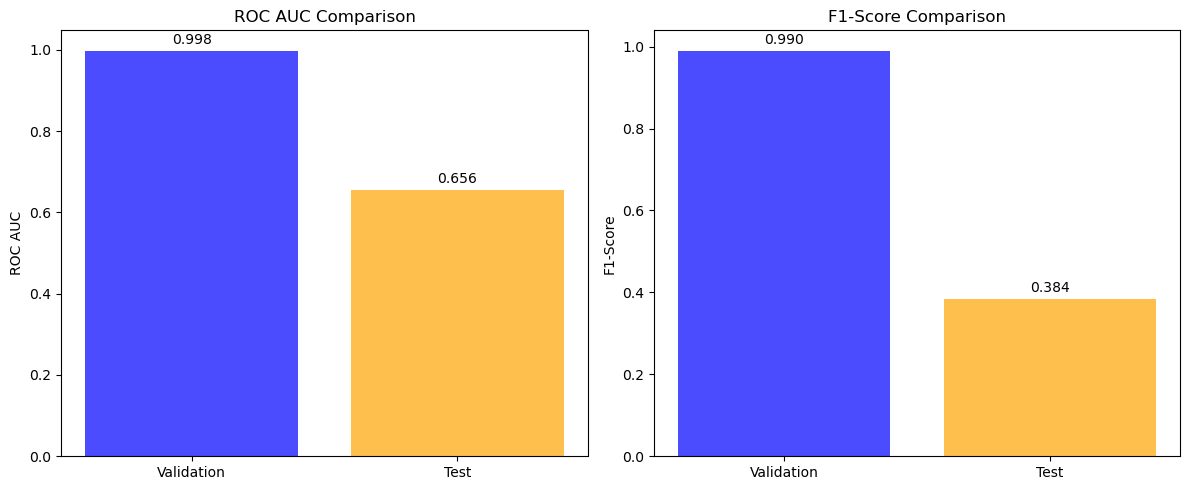

In [19]:
# Compare performance on validation vs test set
val_predictions = final_model.predict(X_val)
val_probs = final_model.predict_proba(X_val)[:, 1]
val_roc_auc = roc_auc_score(y_val, val_probs)
test_roc_auc = test_results['roc_auc']

comparison_df = pd.DataFrame({
    'Dataset': ['Validation', 'Test'],
    'ROC_AUC': [val_roc_auc, test_roc_auc],
    'F1_Score': [f1_score(y_val, val_predictions, average='weighted'), test_results['f1']]
})
print("\nPerformance Comparison:")
print(comparison_df)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# ROC AUC comparison
ax1.bar(comparison_df['Dataset'], comparison_df['ROC_AUC'], color=['blue', 'orange'], alpha=0.7)
ax1.set_title('ROC AUC Comparison')
ax1.set_ylabel('ROC AUC')
for i, v in enumerate(comparison_df['ROC_AUC']):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
# F1-Score comparison
ax2.bar(comparison_df['Dataset'], comparison_df['F1_Score'], color=['blue', 'orange'], alpha=0.7)
ax2.set_title('F1-Score Comparison')
ax2.set_ylabel('F1-Score')
for i, v in enumerate(comparison_df['F1_Score']):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [20]:
#Comparing the model performance with the temperature baseline model
test_results['baselinePred'] = (X_test['tmmx_mean_rt_50_59'] > 300).astype(int)
#Accuracy for both
model_accuracy = accuracy_score(y_test, test_results['predictions'])
baseline_accuracy = accuracy_score(y_test, test_results['baselinePred'])
#Precision for both
model_precision = precision_score(y_test, test_results['predictions'], average='weighted')
baseline_precision = precision_score(y_test, test_results['baselinePred'], average='weighted')
#Recall for both
model_recall = recall_score(y_test, test_results['predictions'], average='weighted')
baseline_recall = recall_score(y_test, test_results['baselinePred'], average='weighted')
#F1 for both
model_f1 = f1_score(y_test, test_results['predictions'], average='weighted')
baseline_f1 = f1_score(y_test, test_results['baselinePred'], average='weighted')
# Create comparison table
comparison_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Random Forest': [model_accuracy, model_precision, model_recall, model_f1],
    'Baseline': [baseline_accuracy, baseline_precision, baseline_recall, baseline_f1],
    'Improvement': [
        model_accuracy - baseline_accuracy,
        model_precision - baseline_precision,
        model_recall - baseline_recall,
        model_f1 - baseline_f1
    ]
})
print("MODEL COMPARISON")
print("=" * 60)
print(comparison_table.round(4))
print("=" * 60)

MODEL COMPARISON
      Metric  Random Forest  Baseline  Improvement
0   Accuracy         0.4784    0.4904      -0.0120
1  Precision         0.6677    0.5401       0.1276
2     Recall         0.4784    0.4904      -0.0120
3   F1-Score         0.3839    0.4745      -0.0907


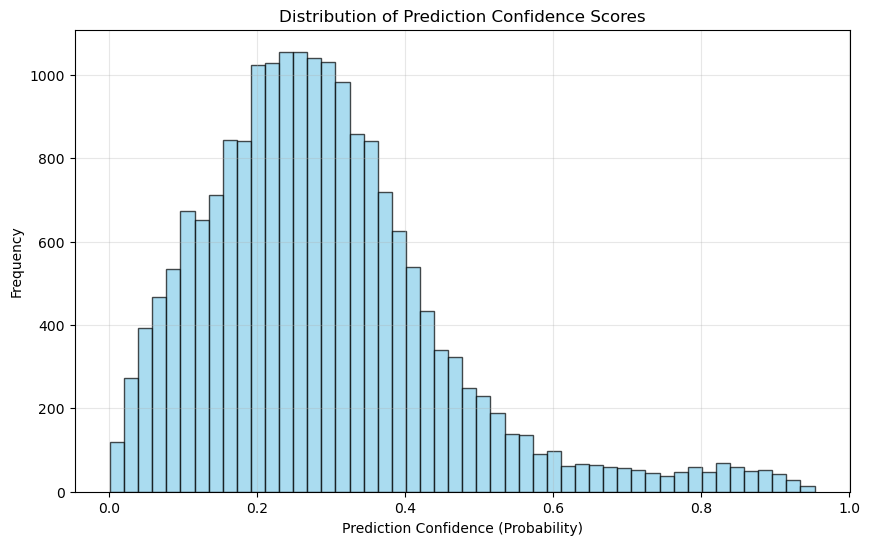

Confidence Statistics:
Mean confidence: 0.2890
Std confidence: 0.1640
Min confidence: 0.0015
Max confidence: 0.9532


In [21]:
#Plotting the confidence score graph for the model
positive_probs = test_results['probabilities'][:, 1]

plt.figure(figsize=(10, 6))
plt.hist(positive_probs, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Prediction Confidence (Probability)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Confidence Scores')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Confidence Statistics:")
print(f"Mean confidence: {positive_probs.mean():.4f}")
print(f"Std confidence: {positive_probs.std():.4f}")
print(f"Min confidence: {positive_probs.min():.4f}")
print(f"Max confidence: {positive_probs.max():.4f}")

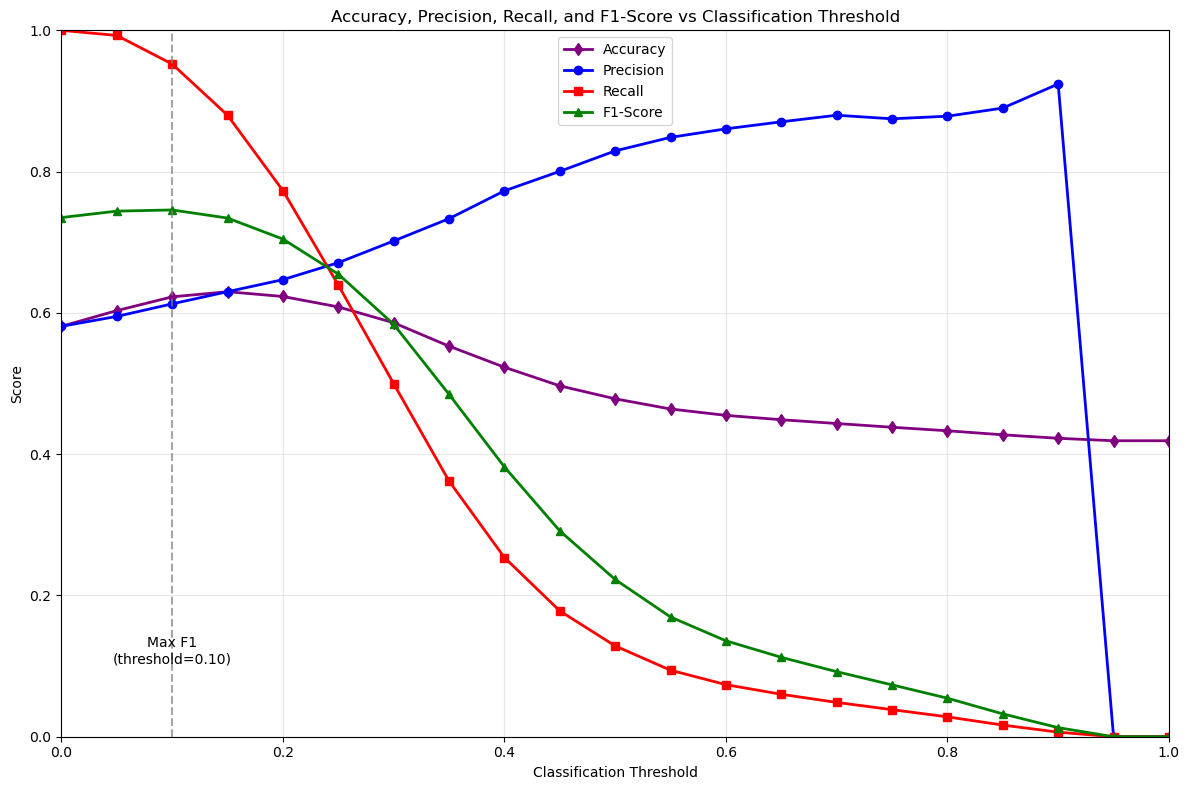

In [22]:
#Plotting the variation of Accuracy, Precision 
thresholds = np.arange(0.0, 1.01, 0.05)
# Initialize lists to store metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
for threshold in thresholds:
    # Apply threshold to get predictions
    threshold_predictions = (positive_probs >= threshold).astype(int)
    # Calculate metrics
    accuracy = accuracy_score(y_test, threshold_predictions)
    precision = precision_score(y_test, threshold_predictions, zero_division=0)
    recall = recall_score(y_test, threshold_predictions, zero_division=0)
    f1 = f1_score(y_test, threshold_predictions, zero_division=0)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(thresholds, accuracies, 'purple', label='Accuracy', linewidth=2, marker='d')
plt.plot(thresholds, precisions, 'b-', label='Precision', linewidth=2, marker='o')
plt.plot(thresholds, recalls, 'r-', label='Recall', linewidth=2, marker='s')
plt.plot(thresholds, f1_scores, 'g-', label='F1-Score', linewidth=2, marker='^')
plt.xlabel('Classification Threshold')
plt.ylabel('Score')
plt.title('Accuracy, Precision, Recall, and F1-Score vs Classification Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
max_f1_idx = np.argmax(f1_scores)
plt.axvline(x=thresholds[max_f1_idx], color='gray', linestyle='--', alpha=0.7)
plt.text(thresholds[max_f1_idx], 0.1, f'Max F1\n(threshold={thresholds[max_f1_idx]:.2f})', 
         ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [23]:
#Find threshold where recall is closest to 0.9 (target recall)
target_recall = 0.9
recall_diff = np.abs(np.array(recalls) - target_recall)
best_idx = np.argmin(recall_diff)
best_threshold = thresholds[best_idx]
best_accuracy = accuracies[best_idx]
best_recall = recalls[best_idx]
best_precision = precisions[best_idx]
best_f1 = f1_scores[best_idx]

# Calculate ROC AUC at threshold = 0.5
threshold_05_predictions = (positive_probs >= 0.5).astype(int)
threshold_05_probs = positive_probs
roc_auc_05 = roc_auc_score(y_test, threshold_05_probs)

# Calculate ROC AUC at recall = 0.9 threshold
recall_09_probs = positive_probs
roc_auc_recall_09 = roc_auc_score(y_test, recall_09_probs)

print("=" * 80)
print(f"THRESHOLD COMPARISON")
print("=" * 80)
print(f"{'Metric':<12} {'Threshold=0.5':<12} {'Recall=0.9':<12}")
print("-" * 80)
print(f"{'Threshold':<12} {0.5:<12.3f} {best_threshold:<12.3f}")
print(f"{'Accuracy':<12} {accuracy_score(y_test, threshold_05_predictions):<12.4f} {best_accuracy:<12.4f}")
print(f"{'Precision':<12} {precision_score(y_test, threshold_05_predictions, zero_division=0):<12.4f} {best_precision:<12.4f}")
print(f"{'Recall':<12} {recall_score(y_test, threshold_05_predictions, zero_division=0):<12.4f} {best_recall:<12.4f}")
print(f"{'F1-Score':<12} {f1_score(y_test, threshold_05_predictions, zero_division=0):<12.4f} {best_f1:<12.4f}")
print(f"{'ROC AUC':<12} {roc_auc_05:<12.4f} {roc_auc_recall_09:<12.4f}")

print(f"\nDetailed analysis for threshold at recall = {target_recall}:")
print(f"Best threshold: {best_threshold:.3f}")
print(f"At this threshold:")
print(f"  - Accuracy:  {best_accuracy:.4f}")
print(f"  - Recall:    {best_recall:.4f}")
print(f"  - Precision: {best_precision:.4f}")
print(f"  - F1-Score:  {best_f1:.4f}")
print(f"  - ROC AUC:   {roc_auc_recall_09:.4f}")

THRESHOLD COMPARISON
Metric       Threshold=0.5 Recall=0.9  
--------------------------------------------------------------------------------
Threshold    0.500        0.150       
Accuracy     0.4784       0.6300      
Precision    0.8293       0.6300      
Recall       0.1286       0.8798      
F1-Score     0.2226       0.7343      
ROC AUC      0.6556       0.6556      

Detailed analysis for threshold at recall = 0.9:
Best threshold: 0.150
At this threshold:
  - Accuracy:  0.6300
  - Recall:    0.8798
  - Precision: 0.6300
  - F1-Score:  0.7343
  - ROC AUC:   0.6556
